In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine, euclidean

import json
from functools import partial
from typing import List

import re
import nltk

from nltk.corpus import stopwords

from collections import Counter
from sklearn.metrics import pairwise_distances
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.probability import FreqDist
from catboost import CatBoostClassifier, Pool
from catboost.utils import eval_metric
from sklearn.model_selection import train_test_split
import gc
from sklearn import preprocessing
from IPython.display import FileLink

In [2]:
nltk.download('wordnet')
from nltk.stem.wordnet import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
nltk.data.path.append("/usr/share/nltk_data")

In [4]:
!python3 -m nltk.downloader wordnet
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpor

## Считывание данных

In [5]:
dataset = pd.read_parquet('/kaggle/input/lct-ozon/hackathon_files_for_participants_ozon/hackathon_files_for_participants_ozon/train_pairs.parquet')
etl = pd.read_parquet('/kaggle/input/lct-ozon/hackathon_files_for_participants_ozon/hackathon_files_for_participants_ozon/train_data.parquet')

In [8]:
dataset.head(2)

,target,variantid1,variantid2
0,0.0,51197862,51198054
1,1.0,53062686,536165289


In [6]:
dataset["target"].value_counts()

0.0    171527
1.0    135013
Name: target, dtype: int64

In [12]:
etl.head(2)

,variantid,name,categories,color_parsed,pic_embeddings_resnet_v1,main_pic_embeddings_resnet_v1,name_bert_64,characteristic_attributes_mapping
0,51195767,"Удлинитель Партнер-Электро ПВС 2х0,75 ГОСТ,6A,...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[оранжевый],None,"[[0.04603629, 0.18839523, -0.09973055, -0.6636...","[-0.47045058, 0.67237014, 0.48984158, -0.54485...","{""Номинальный ток, А"":[""10""],""Цвет товара"":[""о..."
1,53565809,Магнитный кабель USB 2.0 A (m) - USB Type-C (m...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Кабели ...",[красный],"[[0.26863545, -0.3130674, 0.29023397, 0.073978...","[[1.1471839, -0.665361, 0.7745614, 0.26716197,...","[-0.6575592, 0.6522429, 0.5426037, -0.54347897...","{""Конструктивные особенности"":[""Магнитная конс..."


## Common functions

In [27]:
def text_dense_distances(ozon_embedding, comp_embedding):
    """Calculate Euclidean and Cosine distances between
    ozon_embedding and comp_embedding.
    """
    pair_features = []
    if ozon_embedding is None or comp_embedding is None:
        pair_features = [-1, -1]
    elif len(ozon_embedding) == 0 or len(comp_embedding) == 0:
        pair_features = [-1, -1]
    else:
        pair_features.append(
            euclidean(ozon_embedding, comp_embedding)
        )
        cosine_value = cosine(ozon_embedding, comp_embedding)
        
        pair_features.append(cosine_value)

    return pair_features

def get_pic_features(main_pic_embeddings_1,
                     main_pic_embeddings_2,
                     percentiles: List[int]):
    """Calculate distances percentiles for 
    pairwise pic distances. Percentiles are useful 
    when product has several pictures.
    """
    
    if main_pic_embeddings_1 is not None and main_pic_embeddings_2 is not None:
        main_pic_embeddings_1 = np.array([x for x in main_pic_embeddings_1])
        main_pic_embeddings_2 = np.array([x for x in main_pic_embeddings_2])
        
        dist_m = pairwise_distances(
            main_pic_embeddings_1, main_pic_embeddings_2
        )
    else:
        dist_m = np.array([[-1]])

    pair_features = []
    pair_features += np.percentile(dist_m, percentiles).tolist()

    return pair_features


## Очистка текста и создание токенов

In [ ]:
# def text_preprocessing(text):
#     ser = []
#     num_del_rule = r'\b(?:\d+\w*|\w*\d+)\w*\b'
#     spec_del_rule = r'[^a-zA-Zа-яА-Я0-9\s]'
#     del_punkt_rule = r'[^\w\s]'
    
#     text = text.lower() # приведение к нижнему регистру
    
#     text = re.sub(num_del_rule, '', text) # удаление всех чисел
#     text = re.sub(spec_del_rule, '', text) # удаление спец символов
    
#     stop_words = ['для', 'в', 'с', 'под', 'и', 'или', 'на'] + list(stopwords.words('russian'))
#     text = re.sub(del_punkt_rule, '', text) # удаление пунктуации

#     tokens = nltk.word_tokenize(text) # токенизация 
    
#     lemmatizer = WordNetLemmatizer() # лемматизируем текст
#     tokens = [lemmatizer.lemmatize(word) for word in tokens]
#     tokens = [word for word in tokens if word not in stop_words] # удаляем стоп-слова
#     tokens = [word for word in tokens if len(word) > 1] # удаляем слова короче 2х символов
    
    
#     preprocessed_text = ' '.join(tokens) # собираем обработанный текст обратно
#     ser.append(preprocessed_text)
#     ser.append(tokens)
    
#     return ser

In [22]:
def text_prep(text):
    ser = []
    del_punkt_rule = r'[^\w\s]'
    
    text = text.lower() # приведение к нижнему регистру
    
    text = re.sub(del_punkt_rule, '', text) # удаление пунктуации

    tokens = nltk.word_tokenize(text) # токенизация 
    
    lemmatizer = WordNetLemmatizer() # лемматизируем текст
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    preprocessed_text = ' '.join(tokens) # собираем обработанный текст обратно
    ser.append(preprocessed_text)
    ser.append(tokens)
    
    return ser

In [23]:
etl[["name_prep", "name_tok"]] = (
    etl[["name"]].apply(
        lambda x: pd.Series(text_prep(*x)), axis=1
    )
)


## FastText + add it to baseline

In [55]:
!pip install fasttext

In [ ]:
import fasttext
import fasttext.util
fasttext.util.download_model('ru', if_exists='ignore')
ft = fasttext.load_model('cc.ru.300.bin')

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [16]:
def create_fasttext_embedding(text):
    embedding = ft.get_sentence_vector(text)
    return embedding

In [18]:
etl["name_fasttext"] = etl.apply(lambda row: create_fasttext_embedding(row['name_prep']), axis=1)

In [ ]:
features = (
    dataset
    .merge(
        etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [21]:
etl.to_parquet('train_data_new.parquet')
# FileLink(r'train_data_new.parquet') # uncomment if want to download

In [23]:
FileLink(r'train_data_new.parquet')

/kaggle/working/train_data_new.parquet

In [95]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,euclidean_name_preproc_fasttext_dist,cosine_name_preproc_fasttext_dist,cat3,cat3_grouped,name1_prep,name1_tok,name2_prep,name2_tok,name1_fasttext,name2_fasttext
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,0.0,0.0,"Сетевые фильтры, разветвители и удлинители","Сетевые фильтры, разветвители и удлинители",удлинитель tdm electric люкс ул05в 5 м sq13030138,"[удлинитель, tdm, electric, люкс, ул05в, 5, м,...",удлинитель tdm electric люкс ул05в 15 м sq1303...,"[удлинитель, tdm, electric, люкс, ул05в, 15, м...","[0.018795237, -0.02784915, 0.011346684, 0.0014...","[0.0130808, -0.02718922, 0.010845095, -0.00802..."
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,0.0,0.0,"Сетевые фильтры, разветвители и удлинители","Сетевые фильтры, разветвители и удлинители",удлинитель tdm electric люкс ул05в 5 м sq13030138,"[удлинитель, tdm, electric, люкс, ул05в, 5, м,...",удлинитель tdm electric люкс ул05в 3 м sq13030137,"[удлинитель, tdm, electric, люкс, ул05в, 3, м,...","[0.018795237, -0.02784915, 0.011346684, 0.0014...","[0.01654911, -0.026753431, 0.0045313323, -0.00..."


In [28]:
get_pic_features_func = partial(
    get_pic_features,
    percentiles=[0, 25, 50]
)

In [29]:
features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    features[["pic_embeddings_resnet_v11", "pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

In [30]:
features[["euclidean_name_fasttext_dist", "cosine_name_fasttext_dist"]] = (
    features[["name_fasttext1", "name_fasttext2"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

In [78]:
features.head(2)

,target,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,...,name1_tokens,name2_full_preprocessed,name2_tokens,name1_preproc_fasttext,name2_preproc_fasttext,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,euclidean_name_preproc_fasttext_dist,cosine_name_preproc_fasttext_dist
0,0.0,51197862,51198054,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,"[удлинитель, tdm, electric, люкс]",удлинитель tdm electric люкс,"[удлинитель, tdm, electric, люкс]","[0.04962455, -0.011872873, 0.009844726, 0.0552...","[0.04962455, -0.011872873, 0.009844726, 0.0552...",-1.0,-1.0,-1.0,0.0,0.0
1,0.0,51197862,51199884,Удлинитель TDM Electric Люкс УЛ05В 5 м (SQ1303...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Сетевые...",[белый],None,"[[-0.4304909, -0.49474272, -0.46439183, -0.060...","[-0.5104684, 0.56158644, 0.58873796, -0.529718...","{""Число жил"":[""3""],""Макс. нагрузка, Вт"":[""3500...",...,"[удлинитель, tdm, electric, люкс]",удлинитель tdm electric люкс,"[удлинитель, tdm, electric, люкс]","[0.04962455, -0.011872873, 0.009844726, 0.0552...","[0.04962455, -0.011872873, 0.009844726, 0.0552...",-1.0,-1.0,-1.0,0.0,0.0


In [31]:
features["cat3"] = features["categories1"].apply(lambda x: json.loads(x)["3"])
cat3_counts = features["cat3"].value_counts().to_dict()

In [32]:
cntr = 0
for cat3 in cat3_counts:
    if cat3_counts[cat3] < 1_000:
        cntr += cat3_counts[cat3]
        
cntr

10765

In [33]:
features["cat3_grouped"] = features["cat3"].apply(lambda x: x if cat3_counts[x] > 1000 else "rest")

In [ ]:
feats = ["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc",
         'euclidean_name_fasttext_dist', 'cosine_name_fasttext_dist']

X_train, X_test = train_test_split(
    features[feats + ["target", "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=features[["target", "cat3_grouped"]]
)

X_train, X_val = train_test_split(
    X_train[feats + ["target",  "variantid1", "variantid2", "cat3_grouped"]], 
    test_size=0.1, random_state=42, stratify=X_train[["target", "cat3_grouped"]]
)

y_test = X_test[["target", "variantid1", "variantid2"]]
X_test = X_test.drop(["target"], axis=1)

y_train = X_train["target"]
y_val = X_val["target"]

X_train = X_train.drop(["target"], axis=1)
X_val = X_val.drop(["target"], axis=1)


train_pool = Pool(
    data=X_train[feats],
    label=y_train,
)
eval_pool = Pool(
    data=X_val[feats],
    label=y_val,
)

## Modeling

In [37]:
model_fasttext = CatBoostClassifier()

model_fasttext.fit(
    train_pool,
    eval_set=eval_pool,
    plot=True,
    verbose=True,
    use_best_model=True,
    early_stopping_rounds=50,
    metric_period=100
)
model_fasttext.save_model(f"../working/baseline_new_emb.cbm")

X_test["scores"] = model_fasttext.predict_proba(X_test[feats])[:, 1]

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.123728
0:	learn: 0.6680493	test: 0.6672730	best: 0.6672730 (0)	total: 99.9ms	remaining: 1m 39s


100:	learn: 0.5572002	test: 0.5527675	best: 0.5527675 (100)	total: 3.5s	remaining: 31.2s
200:	learn: 0.5468919	test: 0.5439446	best: 0.5439446 (200)	total: 6.83s	remaining: 27.2s
300:	learn: 0.5408179	test: 0.5396075	best: 0.5396075 (300)	total: 10.2s	remaining: 23.6s
400:	learn: 0.5363700	test: 0.5370436	best: 0.5370436 (400)	total: 13.6s	remaining: 20.3s
500:	learn: 0.5328379	test: 0.5353384	best: 0.5353384 (500)	total: 16.8s	remaining: 16.8s
600:	learn: 0.5295474	test: 0.5339604	best: 0.5339604 (600)	total: 20.2s	remaining: 13.4s
700:	learn: 0.5267552	test: 0.5331974	best: 0.5331974 (700)	total: 23.5s	remaining: 10s
800:	learn: 0.5241741	test: 0.5325446	best: 0.5325321 (799)	total: 26.9s	remaining: 6.67s
900:	learn: 0.5216328	test: 0.5317323	best: 0.5317323 (900)	total: 30.6s	remaining: 3.36s
999:	learn: 0.5192541	test: 0.5310849	best: 0.5310697 (997)	total: 33.9s	remaining: 0us

bestTest = 0.5310697434
bestIteration = 997

Shrink model to first 998 iterations.


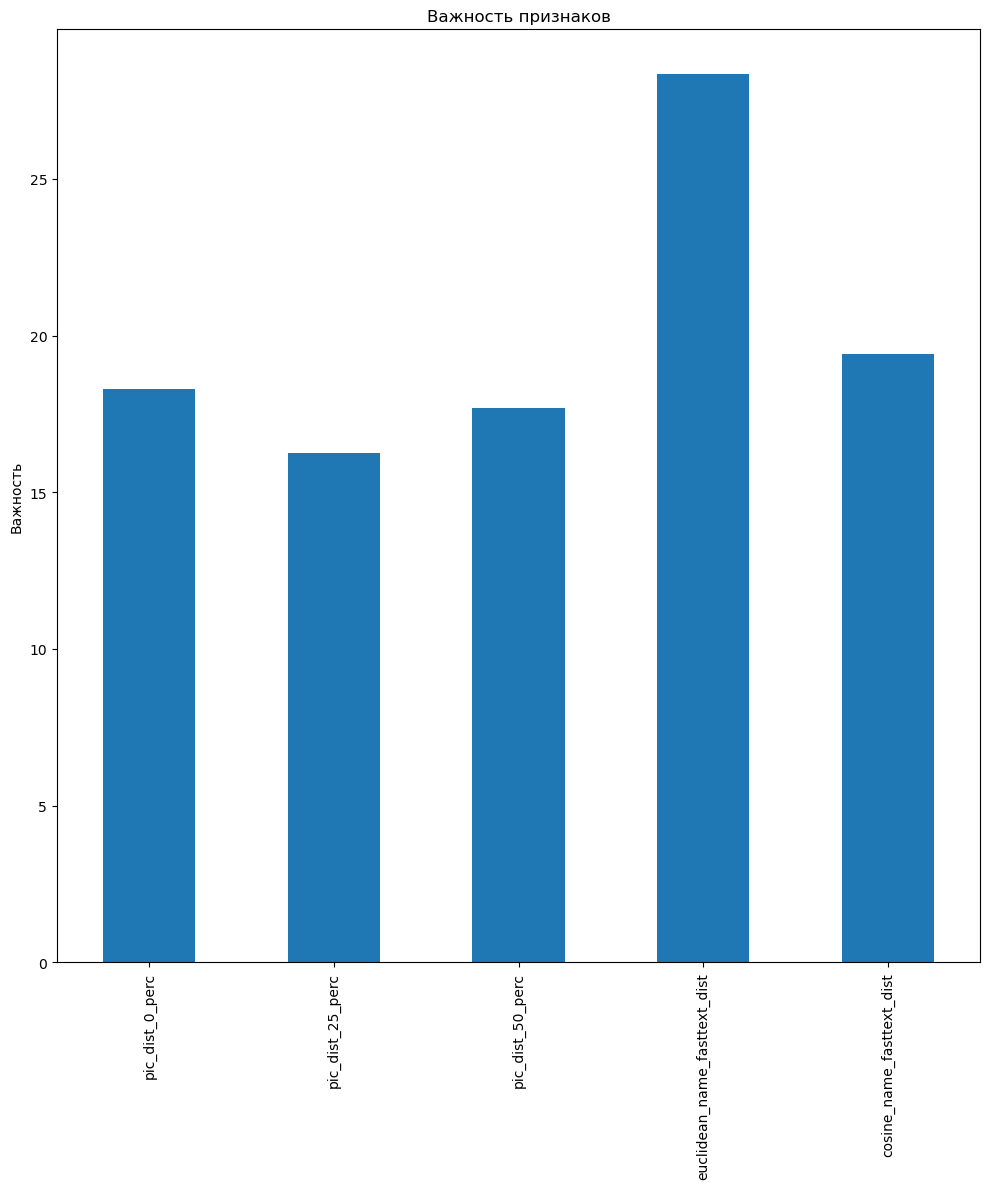

In [38]:
cb_imp = pd.Series(model_fasttext.feature_importances_,
                         features[feats].columns)
fig, ax = plt.subplots(figsize=(10,12))
cb_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Важность')
fig.tight_layout()

## Metric

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, auc


def pr_auc_macro(
    target_df: pd.DataFrame,
    predictions_df: pd.DataFrame,
    prec_level: float = 0.75,
    cat_column: str = "cat3_grouped"
) -> float:

    df = target_df.merge(predictions_df, on=["variantid1", "variantid2"])

    y_true = df["target"]
    y_pred = df["scores"]
    categories = df[cat_column]

    weights = []
    pr_aucs = []

    unique_cats, counts = np.unique(categories, return_counts=True)

    # calculate metric for each big category
    for i, category in enumerate(unique_cats):
        # take just a certain category
        cat_idx = np.where(categories == category)[0]
        y_pred_cat = y_pred[cat_idx]
        y_true_cat = y_true[cat_idx]

        # if there is no matches in the category then PRAUC=0
        if sum(y_true_cat) == 0:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # get coordinates (x, y) for (recall, precision) of PR-curve
        y, x, _ = precision_recall_curve(y_true_cat, y_pred_cat)
        
        # reverse the lists so that x's are in ascending order (left to right)
        y = y[::-1]
        x = x[::-1]
        
        # get indices for x-coordinate (recall) where y-coordinate (precision) 
        # is higher than precision level (75% for our task)
        good_idx = np.where(y >= prec_level)[0]
        
        # if there are more than one such x's (at least one is always there, 
        # it's x=0 (recall=0)) we get a grid from x=0, to the rightest x 
        # with acceptable precision
        if len(good_idx) > 1:
            gt_prec_level_idx = np.arange(0, good_idx[-1] + 1)
        # if there is only one such x, then we have zeros in the top scores 
        # and the curve simply goes down sharply at x=0 and does not rise 
        # above the required precision: PRAUC=0
        else:
            pr_aucs.append(0)
            weights.append(counts[i] / len(categories))
            continue
        
        # calculate category weight anyway
        weights.append(counts[i] / len(categories))
        # calculate PRAUC for all points where the rightest x 
        # still has required precision 
        try:
            pr_auc_prec_level = auc(x[gt_prec_level_idx], y[gt_prec_level_idx])
            if not np.isnan(pr_auc_prec_level):
                pr_aucs.append(pr_auc_prec_level)
        except ValueError:
            pr_aucs.append(0)
            
    return np.average(pr_aucs, weights=weights)


In [41]:
X_test.head(2)

,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,euclidean_name_fasttext_dist,cosine_name_fasttext_dist,variantid1,variantid2,cat3_grouped,scores
305957,-1.000000,-1.000000,-1.00000,0.182472,0.062228,506029509,759875352,Батарейки и аккумуляторы,0.405832
221201,1.102281,3.954101,6.46823,0.180455,0.078199,631006367,634594177,Видеокарты и графические ускорители,0.523261


In [42]:
pr_auc_macro_metr = pr_auc_macro(
    target_df=y_test, 
    predictions_df=X_test,
    prec_level=0.75,
    cat_column="cat3_grouped"
)

pr_auc_macro_metr

0.2438118345613174

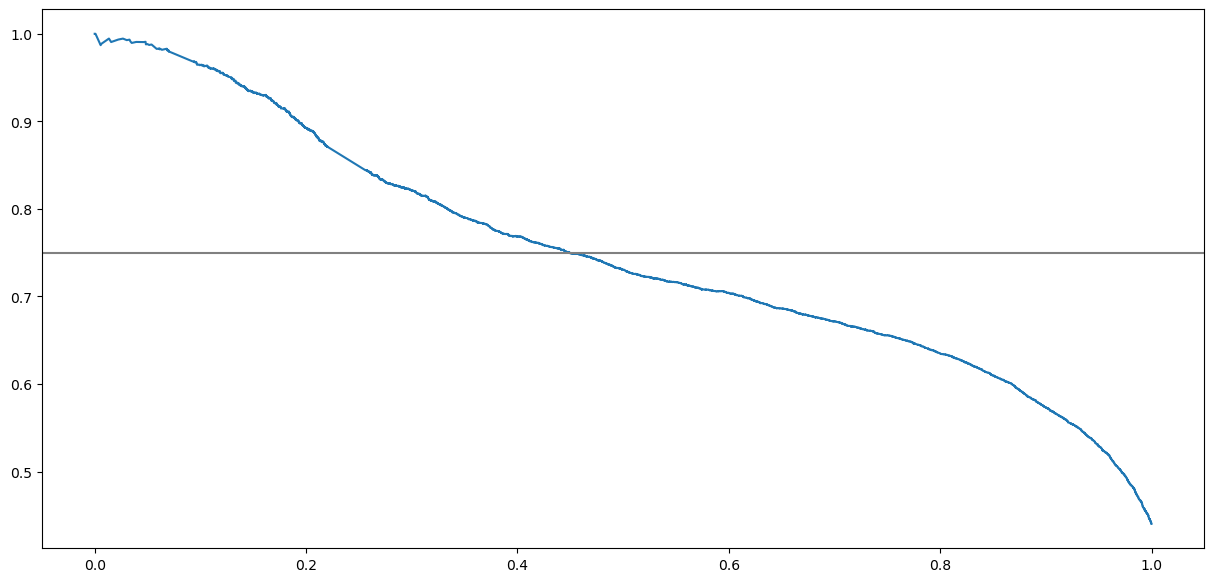

In [43]:
precision, recall, thrs = precision_recall_curve(y_test["target"], X_test["scores"])
pr_auc = auc(recall, precision)

fig, ax1 = plt.subplots(1, figsize=(15, 7))

ax1.plot(recall, precision)
ax1.axhline(y=0.75, color='grey', linestyle='-');

## Submission

In [116]:
test_pairs = pd.read_parquet("../input/lct-ozon/hackathon_files_for_participants_ozon/test_pairs_wo_target.parquet")
test_etl = pd.read_parquet("../input/lct-ozon/hackathon_files_for_participants_ozon/test_data.parquet")

In [117]:
test_features = (
    test_pairs
    .merge(
        test_etl
        .add_suffix('1'),
        on="variantid1"
    )
    .merge(
        test_etl
        .add_suffix('2'),
        on="variantid2"
    )
)

In [118]:
test_features["name1_preprocessed"] = test_features.apply(lambda row: change_dimensions(row['name1']), axis=1)
test_features["name2_preprocessed"] = test_features.apply(lambda row: change_dimensions(row['name2']), axis=1)

In [119]:
test_features["name1_dimensions"] = test_features.apply(lambda row: find_dimensions(row['name1_preprocessed']), axis=1)
test_features["name2_dimensions"] = test_features.apply(lambda row: find_dimensions(row['name2_preprocessed']), axis=1)

In [120]:
test_features["name1_code"] = test_features.apply(lambda row: find_code(row['name1_preprocessed']), axis=1)
test_features["name2_code"] = test_features.apply(lambda row: find_code(row['name2_preprocessed']), axis=1)

In [121]:
test_features["name1_preprocessed"] = test_features.apply(lambda row: change_countr(row['name1_preprocessed']), axis=1)
test_features["name2_preprocessed"] = test_features.apply(lambda row: change_countr(row['name2_preprocessed']), axis=1)

In [122]:
test_features["name1_eng_abbreviations"] = test_features.apply(lambda row: find_eng_abbreviations(row['name1_preprocessed']), axis=1)

test_features["name2_eng_abbreviations"] = test_features.apply(lambda row: find_eng_abbreviations(row['name2_preprocessed']), axis=1)

In [123]:
test_features["name1_model"] = test_features.apply(lambda row: find_model(row['name1_preprocessed']), axis=1)
test_features["name2_model"] = test_features.apply(lambda row: find_model(row['name2_preprocessed']), axis=1)

In [125]:
test_features[["name1_full_preprocessed", "name1_tokens"]] = (
    test_features[["name1"]].apply(
        lambda x: pd.Series(text_preprocessing(*x)), axis=1
    )
)

test_features[["name2_full_preprocessed", "name2_tokens"]] = (
    test_features[["name2"]].apply(
        lambda x: pd.Series(text_preprocessing(*x)), axis=1
    )
)

In [126]:
test_features['name_tokens_jaccard'] = test_features.apply(lambda row: jaccard_similarity(row['name1_tokens'], row['name2_tokens']), axis=1)
test_features['name_dimensions_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name1_dimensions'], row['name2_dimensions']), axis=1)
test_features['name_code_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name1_code'], row['name2_code']), axis=1)


test_features['name_eng_abbreviations_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name1_eng_abbreviations'], 
                                                                                              row['name2_eng_abbreviations']), axis=1)

test_features['name_model_similarity'] = test_features.apply(lambda row: jaccard_similarity(row['name1_model'], row['name2_model']), axis=1)

In [127]:
test_features[["pic_dist_0_perc", "pic_dist_25_perc", "pic_dist_50_perc"]] = (
    test_features[["main_pic_embeddings_resnet_v11", "main_pic_embeddings_resnet_v12"]].apply(
        lambda x: pd.Series(get_pic_features_func(*x)), axis=1
    )
)

test_features[["euclidean_name_bert_dist", "cosine_name_bert_dist"]] = (
    test_features[["name_bert_641", "name_bert_642"]].apply(
        lambda x: pd.Series(text_dense_distances(*x)), axis=1
    )
)

In [128]:
test_features["cat3"] = test_features["categories1"].apply(lambda x: json.loads(x)["3"])

In [129]:
test_cat3_counts = test_features["cat3"].value_counts().to_dict()

cntr = 0
for cat3 in test_cat3_counts:
    if test_cat3_counts[cat3] < 50:
        cntr += test_cat3_counts[cat3]
        
cntr

537

In [130]:
test_features["cat3_grouped"] = test_features["cat3"].apply(lambda x: x if test_cat3_counts[x] > 50 else "rest")

In [152]:
test_features.head(2)

,variantid1,variantid2,name1,categories1,color_parsed1,pic_embeddings_resnet_v11,main_pic_embeddings_resnet_v11,name_bert_641,characteristic_attributes_mapping1,name2,...,name_code_similarity,name_eng_abbreviations_similarity,name_model_similarity,pic_dist_0_perc,pic_dist_25_perc,pic_dist_50_perc,euclidean_name_bert_dist,cosine_name_bert_dist,cat3,cat3_grouped
0,52076340,290590137,Батарейка AAA щелочная Perfeo LR03/10BL Super ...,"{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Батарей...",None,"[[0.15417035, 0.41160947, 0.2213532, -0.019731...","[[0.04763528, -0.20136409, 0.29605597, 0.26453...","[-0.28437558, 0.60909724, 0.5972025, -0.523296...","{""Напряжение, В"":[""1.5""],""Бренд"":[""Perfeo""],""Т...",Батарейка AAA щелочная Perfeo LR03/2BL mini Su...,...,1.0,1.0,0.5,0.449950,0.449950,0.449950,0.719428,0.015745,Батарейки и аккумуляторы,Батарейки и аккумуляторы
1,64525522,204128919,"Смартфон Ulefone Armor X5 3/32 ГБ, черный, кра...","{""1"": ""EPG"", ""2"": ""Электроника"", ""3"": ""Смартфо...","[черный, red, красный]","[[-0.239386, -0.8332473, -0.08384809, 0.071721...","[[-0.27325493, -0.6696304, 0.027148303, 0.0785...","[-0.45766184, 0.5528555, 0.26298037, -0.663931...","{""Операционная система"":[""Android""],""Защищенно...","Смартфон Ulefone Armor X3 2/32 ГБ, черный, кра...",...,1.0,1.0,0.0,3.567521,3.567521,3.567521,0.573571,0.009069,"Смартфоны, планшеты, мобильные телефоны","Смартфоны, планшеты, мобильные телефоны"


In [132]:
submission_test = test_features.copy()

In [138]:
submission_test["target"] = model.predict_proba(test_features[feats])[:, 1]

In [139]:
submission_test.head(2)

,variantid1,variantid2,scores,target
0,52076340,290590137,0.477636,0.477636
1,64525522,204128919,0.177769,0.177769


In [153]:
submission_test = submission_test[["variantid1", "variantid2", "target"]]

In [154]:
submission_test.head(2)

,variantid1,variantid2,target
0,52076340,290590137,0.477636
1,64525522,204128919,0.177769


In [156]:
submission_test.drop_duplicates().merge(
    test_features[["variantid1", "variantid2"]].drop_duplicates(["variantid1", "variantid2"]),
    on=["variantid1", "variantid2"]
).to_csv("submission1.csv", index=False)